### Import Libraries and Read Data

In [58]:
## Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plt.rcParams['figure.figsize'] = [15, 8]
from IPython import display
from ipywidgets import interact, widgets
from scipy import optimize

## Read Data for Cases, Deaths and Recoveries
ConfirmedCases_raw=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
Deaths_raw=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
Recoveries_raw=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
Countrypop_raw=pd.read_csv('https://covid.ourworldindata.org/data/ecdc/locations.csv')

In [59]:
ConfirmedCases_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,933,996,1026,1092,1176,1279,1351,1463,1531,1703
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,548,562,584,609,634,663,678,712,726,736
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,704,713,717,717,723,723,731,738,738,743
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,24,24,24,24,25,25,25,25,26,27


In [60]:
Countrypop_raw.head()

,countriesAndTerritories,location,continent,population_year,population
0,Afghanistan,Afghanistan,Asia,2020.0,38928341.0
1,Albania,Albania,Europe,2020.0,2877800.0
2,Algeria,Algeria,Africa,2020.0,43851043.0
3,Andorra,Andorra,Europe,2020.0,77265.0
4,Angola,Angola,Africa,2020.0,32866268.0


In [61]:
### Melt the dateframe into the right shape and set index
def cleandata(df_raw, drop_country=None):
    df_cleaned=df_raw.melt(id_vars=['Province/State','Country/Region','Lat','Long'],value_name='Cases',var_name='Date')
    df_cleaned=df_cleaned.set_index(['Country/Region','Province/State','Date'])
    if drop_country:
        df_cleaned.drop(drop_country, level=0, inplace=True)
    return df_cleaned 

### Get Countrywise Data
def countrydata(df_cleaned,oldname,newname):
    df_country=df_cleaned.groupby(['Country/Region','Date'])['Cases'].sum().reset_index()
    df_country=df_country.set_index(['Country/Region','Date'])
    df_country.index=df_country.index.set_levels([df_country.index.levels[0], pd.to_datetime(df_country.index.levels[1])])
    df_country=df_country.sort_values(['Country/Region','Date'],ascending=True)
    df_country=df_country.rename(columns={oldname:newname})
    return df_country

### Get DailyData from Cumulative sum
def dailydata(dfcountry,oldname,newname):
    dfcountrydaily=dfcountry.groupby(level=0).diff().fillna(0)
    dfcountrydaily=dfcountrydaily.rename(columns={oldname:newname})
    return dfcountrydaily

In [62]:
### procedure to index population data 
def cleanpop(df_raw):
    df_cleaned=df_raw.set_index(['countriesAndTerritories'])
    return df_cleaned

In [63]:
### index population
countrypop = cleanpop(Countrypop_raw)

In [64]:
countrypop.loc['Sweden'].at['population']

10099270.0

In [65]:
countrypop.loc['Sweden']

location                Sweden
continent               Europe
population_year           2020
population         1.00993e+07
Name: Sweden, dtype: object

In [66]:
countrypop.rename(index = {"United_Kingdom": "United Kingdom", 
                     "United_States_of_America":"US"}, 
                                 inplace = True) 

In [67]:
countrypop.tail(13)

,location,continent,population_year,population
countriesAndTerritories,,,,
United_Arab_Emirates,United Arab Emirates,Asia,2020.0,9890400.0
United Kingdom,United Kingdom,Europe,2020.0,67886004.0
United_Republic_of_Tanzania,Tanzania,Africa,2020.0,59734213.0
United_States_Virgin_Islands,United States Virgin Islands,North America,2020.0,104423.0
US,United States,North America,2020.0,331002647.0
Uruguay,Uruguay,South America,2020.0,3473727.0
Uzbekistan,Uzbekistan,Asia,2020.0,33469199.0
Venezuela,Venezuela,South America,2020.0,28435943.0
Vietnam,Vietnam,Asia,2020.0,97338583.0


In [68]:
# Clean all datasets
ConfirmedCases=cleandata(ConfirmedCases_raw, ['China', 'Mainland China'])
Deaths=cleandata(Deaths_raw, ['China', 'Mainland China'])
Recoveries=cleandata(Recoveries_raw, ['China', 'Mainland China'])

In [69]:
ConfirmedCases.tail(8)

,,,Lat,Long,Cases
Country/Region,Province/State,Date,,,
Netherlands,"Bonaire, Sint Eustatius and Saba",4/27/20,12.178400,-68.238500,5
Malawi,NaN,4/27/20,-13.254308,34.301525,36
United Kingdom,Falkland Islands (Malvinas),4/27/20,-51.796300,-59.523600,13
France,Saint Pierre and Miquelon,4/27/20,46.885200,-56.315900,1
South Sudan,NaN,4/27/20,6.877000,31.307000,6
Western Sahara,NaN,4/27/20,24.215500,-12.885800,6
Sao Tome and Principe,NaN,4/27/20,0.186360,6.613081,4
Yemen,NaN,4/27/20,15.552727,48.516388,1


In [70]:
# Get countrywise data
ConfirmedCasesCountry=countrydata(ConfirmedCases,'Cases','Total Confirmed Cases')
DeathsCountry=countrydata(Deaths,'Cases','Total Deaths')
RecoveriesCountry=countrydata(Recoveries,'Cases','Total Recoveries')

In [71]:
# Get Daily Data
NewCasesCountry=dailydata(ConfirmedCasesCountry,'Total Confirmed Cases','Daily New Cases')
NewDeathsCountry=dailydata(DeathsCountry,'Total Deaths','Daily New Deaths')
NewRecoveriesCountry=dailydata(RecoveriesCountry,'Total Recoveries','Daily New Recoveries')

In [72]:
CountryConsolidated=pd.merge(ConfirmedCasesCountry,NewCasesCountry,how='left',left_index=True,right_index=True)
CountryConsolidated=pd.merge(CountryConsolidated,NewDeathsCountry,how='left',left_index=True,right_index=True)
CountryConsolidated=pd.merge(CountryConsolidated,DeathsCountry,how='left',left_index=True,right_index=True)
CountryConsolidated=pd.merge(CountryConsolidated,RecoveriesCountry,how='left',left_index=True,right_index=True)
CountryConsolidated=pd.merge(CountryConsolidated,NewRecoveriesCountry,how='left',left_index=True,right_index=True)
CountryConsolidated['Active Cases']=CountryConsolidated['Total Confirmed Cases']-CountryConsolidated['Total Deaths']-CountryConsolidated['Total Recoveries']
CountryConsolidated['Share of Recoveries - Closed Cases']=np.round(CountryConsolidated['Total Recoveries']/(CountryConsolidated['Total Recoveries']+CountryConsolidated['Total Deaths']),2)
CountryConsolidated['Death to Cases Ratio']=np.round(CountryConsolidated['Total Deaths']/CountryConsolidated['Total Confirmed Cases'],3)

In [73]:
GlobalTotals=CountryConsolidated.reset_index().groupby('Date').sum()
GlobalTotals['Share of Recoveries - Closed Cases']=np.round(GlobalTotals['Total Recoveries']/(GlobalTotals['Total Recoveries']+GlobalTotals['Total Deaths']),2)
GlobalTotals['Death to Cases Ratio']=np.round(GlobalTotals['Total Deaths']/GlobalTotals['Total Confirmed Cases'],3)
GlobalTotals.tail(2)

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-04-26,2888451,74736.0,3699.0,201931,787456,47793.0,1899064,0.8,0.07
2020-04-27,2957846,69395.0,4599.0,206530,815593,28137.0,1935723,0.8,0.07


In [74]:
GlobalTotals.iloc[-1]

Total Confirmed Cases                 2957846.00
Daily New Cases                         69395.00
Daily New Deaths                         4599.00
Total Deaths                           206530.00
Total Recoveries                       815593.00
Daily New Recoveries                    28137.00
Active Cases                          1935723.00
Share of Recoveries - Closed Cases          0.80
Death to Cases Ratio                        0.07
Name: 2020-04-27 00:00:00, dtype: float64

In [75]:
total_death = GlobalTotals.iloc[-1]['Total Deaths']
total_recoveries = GlobalTotals.iloc[-1]['Total Recoveries']
total_closed = total_death + total_recoveries

In [76]:
total_death / total_closed

0.20205983037266553

In [77]:
plt.style.use('seaborn-dark')

## Logistic Model Fit
Let's try to fit a model to the data

In [78]:
GlobalTotals.iloc[-1]

Total Confirmed Cases                 2957846.00
Daily New Cases                         69395.00
Daily New Deaths                         4599.00
Total Deaths                           206530.00
Total Recoveries                       815593.00
Daily New Recoveries                    28137.00
Active Cases                          1935723.00
Share of Recoveries - Closed Cases          0.80
Death to Cases Ratio                        0.07
Name: 2020-04-27 00:00:00, dtype: float64

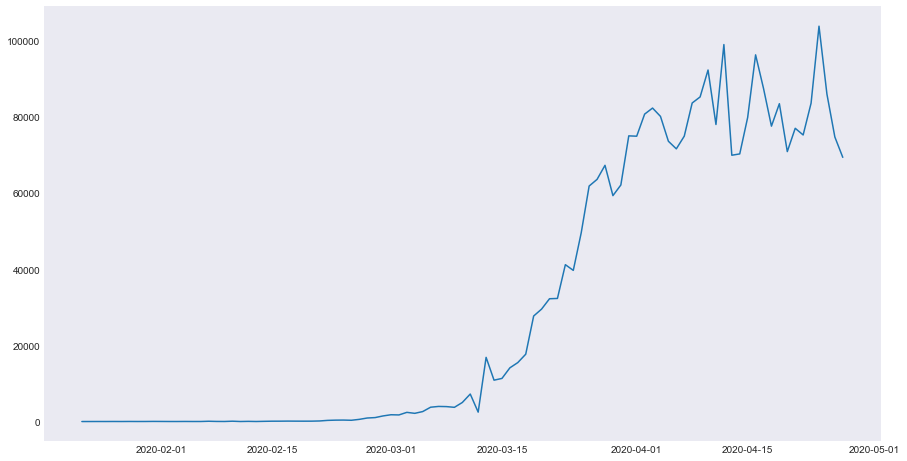

In [79]:
plt.plot(GlobalTotals['Daily New Cases'])

In [80]:
# Cases by Region (inside or Outside China)
TotalCasesLoc=CountryConsolidated.reset_index()
TotalCasesLocaggregated=TotalCasesLoc.groupby(['Date'])['Total Confirmed Cases'].sum().reset_index()
TotalCasesLocaggregated.tail(5)

,Date,Total Confirmed Cases
92,2020-04-23,2623858
93,2020-04-24,2727704
94,2020-04-25,2813715
95,2020-04-26,2888451
96,2020-04-27,2957846


In [81]:
var_range = np.arange(0.0,0.1,0.03)
var_range

array([0.  , 0.03, 0.06, 0.09])

In [82]:
df = TotalCasesLocaggregated.set_index('Date')
y_data = df['Total Confirmed Cases'].values
daily_new_cases = GlobalTotals.iloc[-1]['Daily New Cases']

def logistic(x, a, b, c):
     y = c / (1 + np.exp(-b*(x-a)))
     return y

var_params = []
var_dict = {}
for variance in var_range:
    y = y_data.copy()
    #y[-1] = y[-1] * (1 + variance)
    y = np.append(y, y[-1] + daily_new_cases * (1 + variance))
    x = np.array(range(len(y)))
    params, params_covariance = optimize.curve_fit(logistic, x, y, p0=[50, 0.1, 10000000], maxfev=10000)
    var_dict[variance] = params
    var_params.append(params)
    print(params)

[8.02969681e+01 1.13975450e-01 3.36010886e+06]
[8.03036464e+01 1.13946004e-01 3.36119124e+06]
[8.03103312e+01 1.13916555e-01 3.36227491e+06]
[8.03170226e+01 1.13887103e-01 3.36335988e+06]


(737486.0, 737547.1859856631)

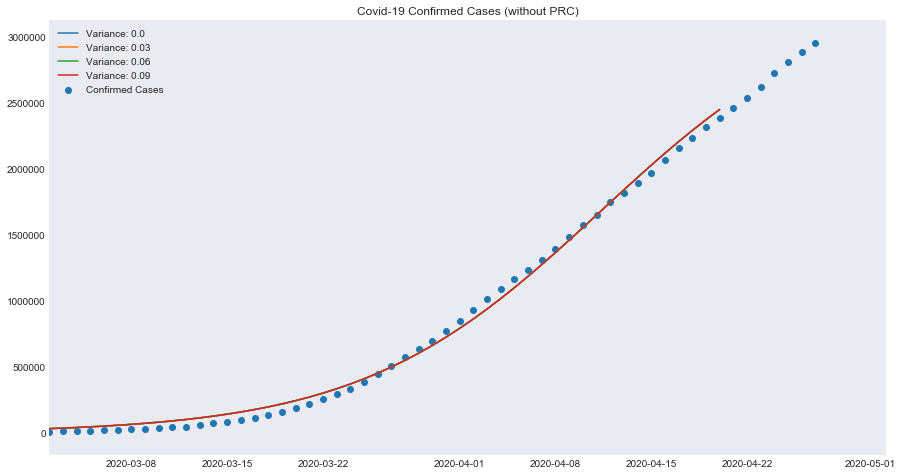

In [83]:
rg = np.array(range(90))
dr1 = pd.date_range(df.index[0], periods=90)
dr2 = pd.date_range(df.index[0], periods=len(df.index))
for variance in var_dict.keys():
    fit_params = var_dict[variance]
    plt.plot(dr1, logistic(rg, *fit_params), label='Variance: {}'.format(round(variance, 3)))
plt.scatter(dr2, y_data, label='Confirmed Cases')
plt.legend(loc='best')
plt.title('Covid-19 Confirmed Cases (without PRC)')
plt.xlim(left=df.index[40])

Text(0.5, 1.0, 'Covid-19 Confirmed Cases (without PRC)')

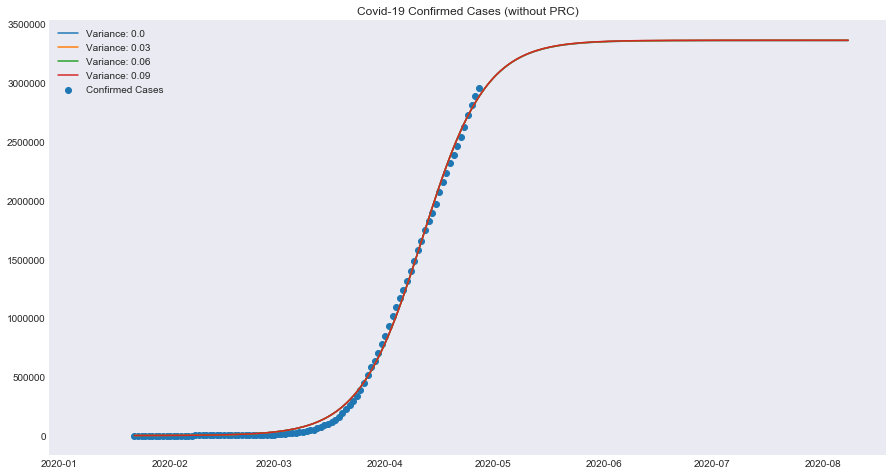

In [84]:
rg = np.array(range(200))
dr1 = pd.date_range(df.index[0], periods=200)
dr2 = pd.date_range(df.index[0], periods=len(df.index))
plt.scatter(dr2, y_data, label='Confirmed Cases')
for variance in var_dict.keys():
    fit_params = var_dict[variance]
    plt.plot(dr1, logistic(rg, *fit_params), label='Variance: {}'.format(round(variance, 2)))
plt.legend(loc='best')
plt.title('Covid-19 Confirmed Cases (without PRC)')

In [85]:
ItalyFirstCase=CountryConsolidated.loc['Italy']['Total Confirmed Cases'].reset_index().set_index('Date')
SKFirstCase=CountryConsolidated.loc['Korea, South']['Total Confirmed Cases'].reset_index().set_index('Date')
IranFirstCase=CountryConsolidated.loc['Iran']['Total Confirmed Cases'].reset_index().set_index('Date')
GermanyFirstCase=CountryConsolidated.loc['Germany']['Total Confirmed Cases'].reset_index().set_index('Date')
SingaporeFirstCase=CountryConsolidated.loc['Singapore']['Total Confirmed Cases'].reset_index().set_index('Date')

ItalyGrowth=ItalyFirstCase[ItalyFirstCase.ne(0)].dropna().reset_index()
SKGrowth=SKFirstCase[SKFirstCase.ne(0)].dropna().reset_index()
IranGrowth=IranFirstCase[IranFirstCase.ne(0)].dropna().reset_index()
GermanyGrowth=GermanyFirstCase[GermanyFirstCase.ne(0)].dropna().reset_index()
SingaporeGrowth=SingaporeFirstCase[SingaporeFirstCase.ne(0)].dropna().reset_index()

In [86]:
ItalyGrowth.tail(3)

,Date,Total Confirmed Cases
85,2020-04-25,195351.0
86,2020-04-26,197675.0
87,2020-04-27,199414.0


In [87]:
chartcol='red'
fig = make_subplots(rows=2, cols=2,shared_xaxes=True,
                   subplot_titles=('Italy','Iran','South Korea','Germany'))

fig.update_xaxes(title_text="Number of Days since Outbreak", row=2, col=1)

fig.update_xaxes(title_text="Number of Days since Outbreak", row=2, col=2)

fig.add_trace(go.Scatter(x=ItalyGrowth.index,y=ItalyGrowth['Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                          row=1,col=1)
fig.add_trace(go.Scatter(x=IranGrowth.index,y=IranGrowth['Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                          row=1,col=2)
                           
fig.add_trace(go.Scatter(x=SKGrowth.index,y=SKGrowth['Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                          row=2,col=1)    
                           
fig.add_trace(go.Scatter(x=GermanyGrowth.index,y=GermanyGrowth['Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                          row=2,col=2)  

fig.update_layout(showlegend=False,title = 'Total Confirmed Cases')



## Evaluation per Country
enter country after countryname below

In [166]:
countryname = 'United Kingdom'

In [167]:
country = CountryConsolidated.loc[countryname].copy()
country.tail(10)

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-04-18,115314,5545.0,891.0,15498,414,20.0,99402,0.03,0.134
2020-04-19,121172,5858.0,597.0,16095,436,22.0,104641,0.03,0.133
2020-04-20,125856,4684.0,455.0,16550,446,10.0,108860,0.03,0.131
2020-04-21,130172,4316.0,828.0,17378,638,192.0,112156,0.04,0.134
2020-04-22,134638,4466.0,773.0,18151,683,45.0,115804,0.04,0.135
2020-04-23,139246,4608.0,640.0,18791,712,29.0,119743,0.04,0.135
2020-04-24,144640,5394.0,776.0,19567,724,12.0,124349,0.04,0.135
2020-04-25,149569,4929.0,814.0,20381,774,50.0,128414,0.04,0.136
2020-04-26,154037,4468.0,413.0,20794,778,4.0,132465,0.04,0.135


In [168]:
country['Total Confirmed Cases'].tail(10)

Date
2020-04-18    115314
2020-04-19    121172
2020-04-20    125856
2020-04-21    130172
2020-04-22    134638
2020-04-23    139246
2020-04-24    144640
2020-04-25    149569
2020-04-26    154037
2020-04-27    158348
Name: Total Confirmed Cases, dtype: int64

Text(0, 0.5, 'Total Confirmed ')

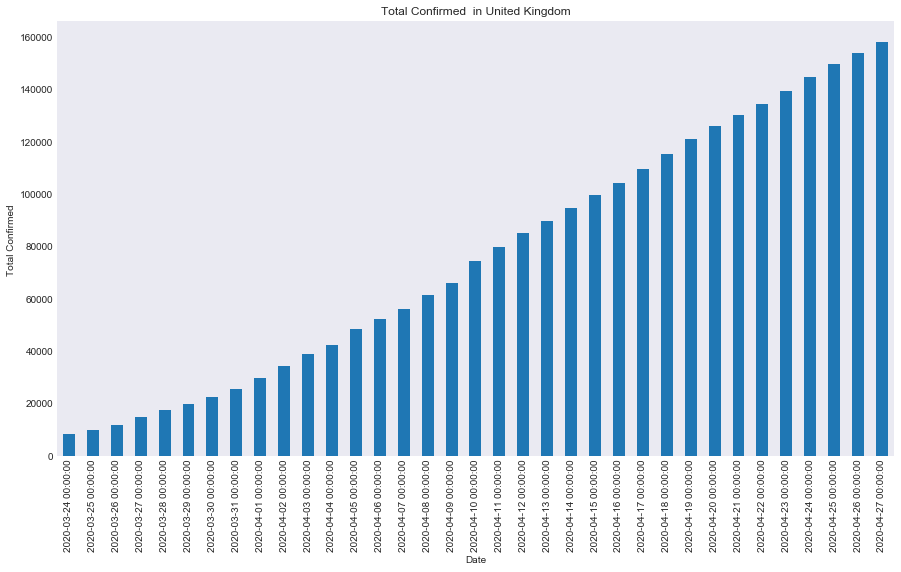

In [169]:
country['Total Confirmed Cases'].iloc[-35:].plot.bar()
plt.title('Total Confirmed  in '+countryname)
plt.ylabel('Total Confirmed ')

In [170]:
country['Daily New Cases'].tail(10)

Date
2020-04-18    5545.0
2020-04-19    5858.0
2020-04-20    4684.0
2020-04-21    4316.0
2020-04-22    4466.0
2020-04-23    4608.0
2020-04-24    5394.0
2020-04-25    4929.0
2020-04-26    4468.0
2020-04-27    4311.0
Name: Daily New Cases, dtype: float64

Text(0, 0.5, 'Number of cases')

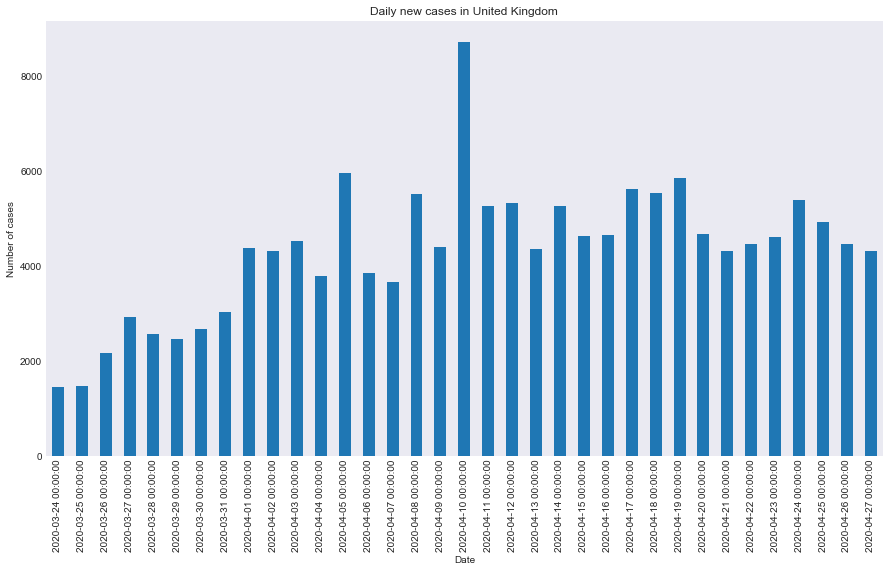

In [171]:
country['Daily New Cases'].iloc[-35:].plot.bar()
plt.title('Daily new cases in '+countryname)
plt.ylabel('Number of cases')

In [172]:
country['growth rate'] = country['Daily New Cases'] / country['Active Cases']*100

In [173]:
country['growth rate'].tail(10)

Date
2020-04-18    5.578359
2020-04-19    5.598188
2020-04-20    4.302774
2020-04-21    3.848211
2020-04-22    3.856516
2020-04-23    3.848242
2020-04-24    4.337791
2020-04-25    3.838367
2020-04-26    3.372966
2020-04-27    3.160928
Name: growth rate, dtype: float64

Text(0, 0.5, 'Growth rate in %')

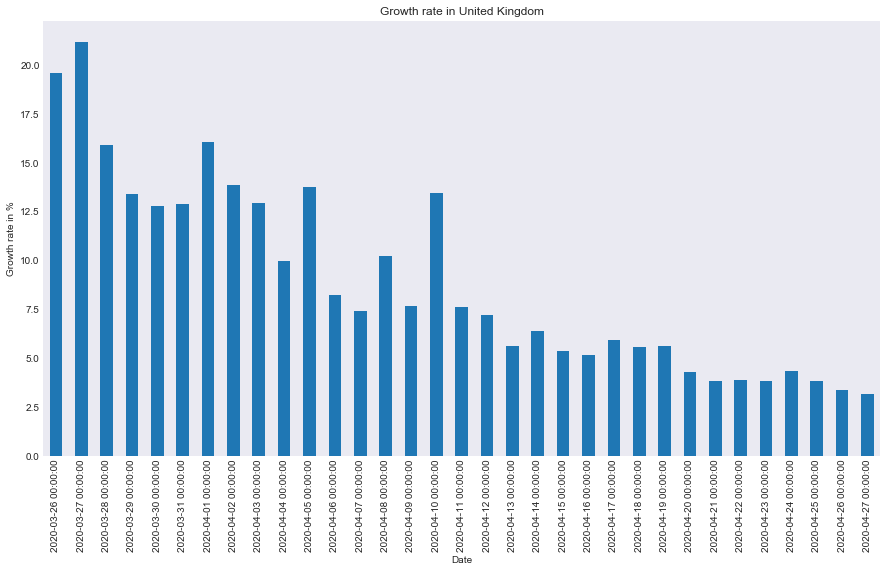

In [174]:
country['growth rate'].iloc[-33:].plot.bar()
plt.title('Growth rate in '+countryname)
plt.ylabel('Growth rate in %')

# Deaths
Number of deaths, ratios and trends


In [175]:
country['Total Deaths'].tail(10)

Date
2020-04-18    15498
2020-04-19    16095
2020-04-20    16550
2020-04-21    17378
2020-04-22    18151
2020-04-23    18791
2020-04-24    19567
2020-04-25    20381
2020-04-26    20794
2020-04-27    21157
Name: Total Deaths, dtype: int64

Text(0, 0.5, 'Number of Deaths Total')

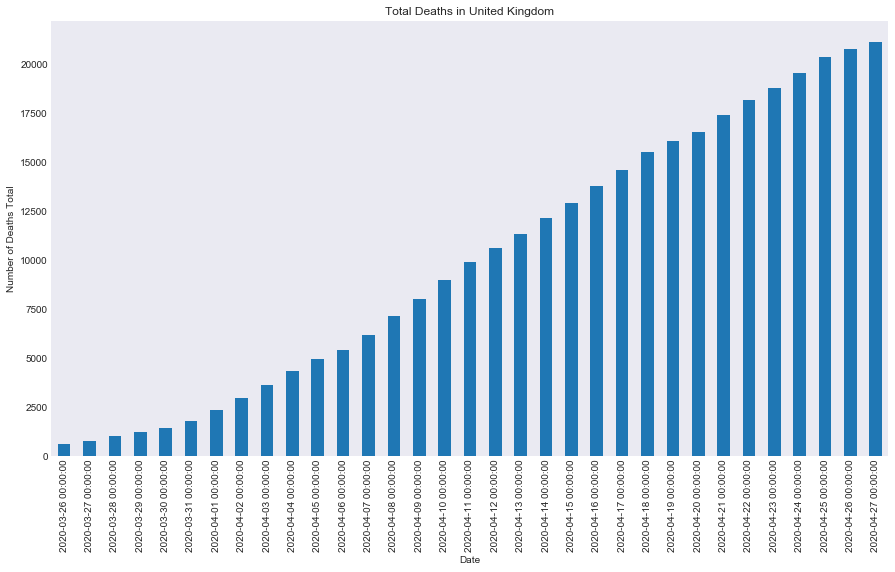

In [176]:
country['Total Deaths'].iloc[-33:].plot.bar()
plt.title('Total Deaths in '+countryname)
plt.ylabel('Number of Deaths Total')

In [177]:
country['Daily New Deaths'].tail(10)

Date
2020-04-18    891.0
2020-04-19    597.0
2020-04-20    455.0
2020-04-21    828.0
2020-04-22    773.0
2020-04-23    640.0
2020-04-24    776.0
2020-04-25    814.0
2020-04-26    413.0
2020-04-27    363.0
Name: Daily New Deaths, dtype: float64

Text(0, 0.5, 'Daily New Deaths')

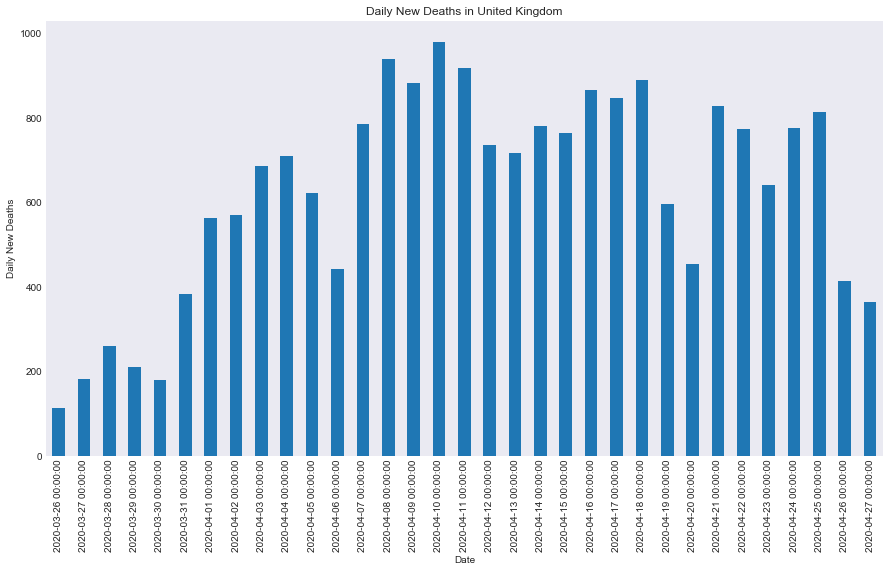

In [178]:
country['Daily New Deaths'].iloc[-33:].plot.bar()
plt.title('Daily New Deaths in '+countryname)
plt.ylabel('Daily New Deaths')

In [179]:
country['deaths per total cases'] = country['Total Deaths'] / country['Total Confirmed Cases'] * 100

In [180]:
country['deaths per total cases'].tail(10)

Date
2020-04-18    13.439825
2020-04-19    13.282772
2020-04-20    13.149949
2020-04-21    13.350029
2020-04-22    13.481335
2020-04-23    13.494822
2020-04-24    13.528070
2020-04-25    13.626487
2020-04-26    13.499354
2020-04-27    13.361078
Name: deaths per total cases, dtype: float64

Text(0, 0.5, 'Deaths per total cases in %')

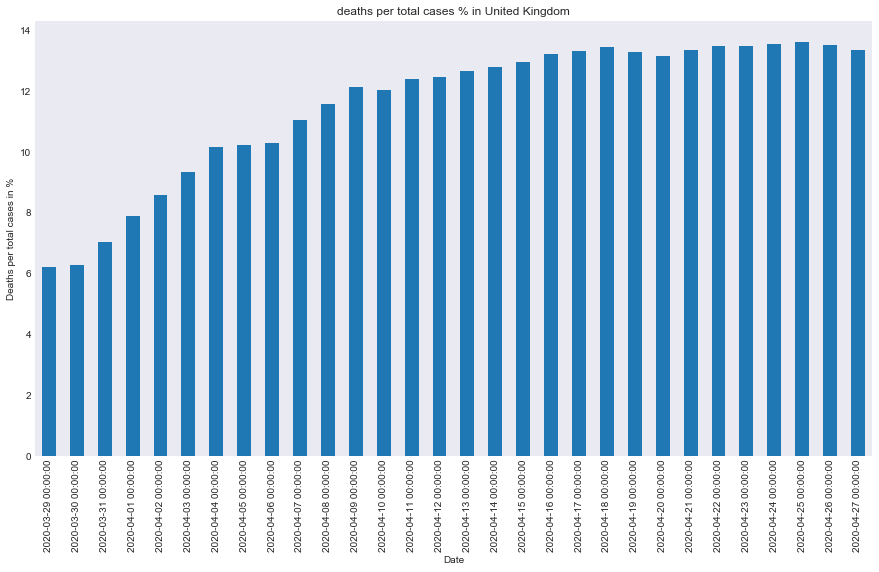

In [181]:
country['deaths per total cases'].iloc[-30:].plot.bar()
plt.title('deaths per total cases % in '+countryname)
plt.ylabel('Deaths per total cases in %')

In [182]:
country['death rate'] = country['Daily New Deaths'] / country['Total Deaths'] * 100

In [183]:
country['death rate'].tail(10)

Date
2020-04-18    5.749129
2020-04-19    3.709226
2020-04-20    2.749245
2020-04-21    4.764645
2020-04-22    4.258719
2020-04-23    3.405886
2020-04-24    3.965861
2020-04-25    3.993916
2020-04-26    1.986150
2020-04-27    1.715744
Name: death rate, dtype: float64

Text(0, 0.5, 'Death rate in %')

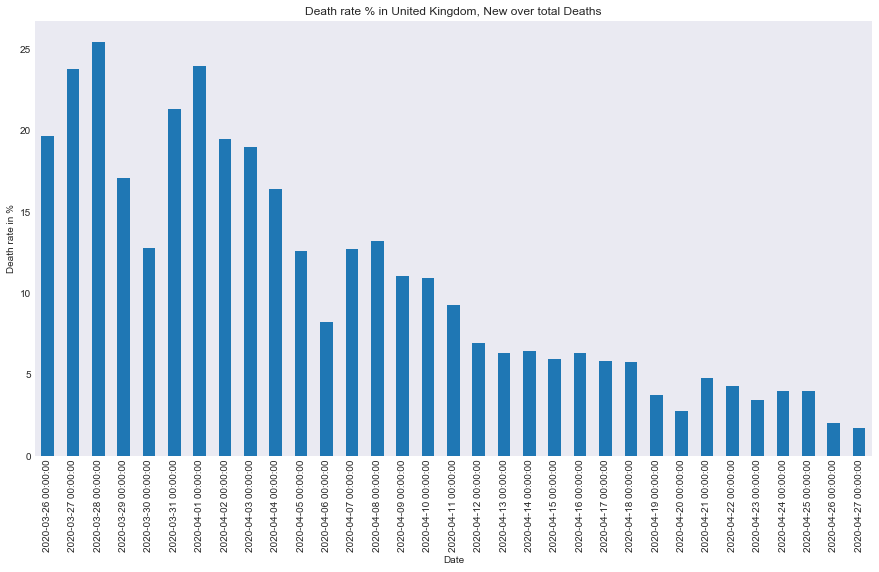

In [184]:
country['death rate'].iloc[-33:].plot.bar()
plt.title('Death rate % in '+countryname+', New over total Deaths') 
plt.ylabel('Death rate in %')

# Active Cases

In [185]:
country['active cases'] = country['Total Confirmed Cases'] - country['Total Recoveries'] - country['Total Deaths']

In [186]:
country['active cases'].tail(10)

Date
2020-04-18     99402
2020-04-19    104641
2020-04-20    108860
2020-04-21    112156
2020-04-22    115804
2020-04-23    119743
2020-04-24    124349
2020-04-25    128414
2020-04-26    132465
2020-04-27    136384
Name: active cases, dtype: int64

Text(0, 0.5, 'Active Cases')

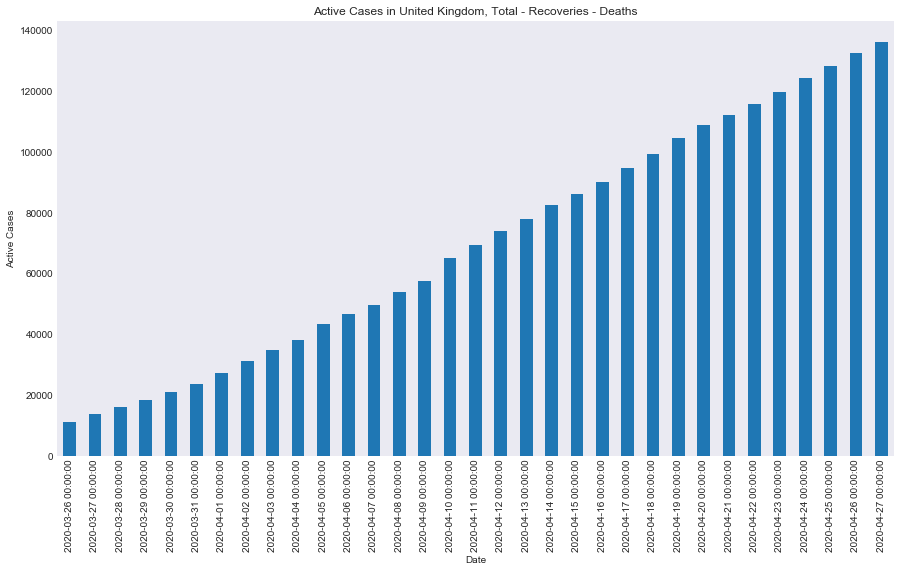

In [187]:
country['active cases'].iloc[-33:].plot.bar()
plt.title('Active Cases in '+countryname+', Total - Recoveries - Deaths') 
plt.ylabel('Active Cases')

In [188]:
countrypop.loc[countryname]

location           United Kingdom
continent                  Europe
population_year              2020
population             6.7886e+07
Name: United Kingdom, dtype: object

In [189]:
population = countrypop.loc[countryname].at['population']

In [190]:
country['Death per Million'] = country['Total Deaths'] / population * 1000000

In [191]:
country['Death per Million'].tail(5)

Date
2020-04-23    276.802270
2020-04-24    288.233198
2020-04-25    300.223887
2020-04-26    306.307615
2020-04-27    311.654815
Name: Death per Million, dtype: float64